# 🐥 **20-03-2024**

In [44]:
# from __future__ import print_function

from audio_sheet_retrieval.utils.data_pools import prepare_piece_data, AudioScoreRetrievalPool
import sys
import yaml
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import cv2
from msmd.data_model.piece import Piece


# Enable autoreload
%load_ext autoreload

# Set autoreload mode to reload all modules every time before executing code
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# config_file = '/home/I6194030/audio_sheet_retrieval/audio_sheet_retrieval/exp_configs/mutopia_no_aug.yaml'
# DATA_ROOT_MSMD = '/home/I6194030/msmd/msmd_aug_v1-1_no-audio'
# snippets_output_dir = "/home/I6194030/audio_sheet_retrieval/DATA_COLLECTION"

split_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd/msmd/splits/all_split.yaml'
config_file = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/audio_sheet_retrieval/exp_configs/mutopia_no_aug.yaml'
DATA_ROOT_MSMD = '/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/msmd_aug_v1-1_no-audio'
snippets_output_dir = "/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3"
# snippets_output_dir = "/Users/margarita/PleyelIJ__pleyel-menuett__pleyel-menuett"






with open(config_file, 'rb') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)



SHEET_CONTEXT = 180
SYSTEM_HEIGHT = 160
SPEC_CONTEXT = 20
SPEC_BINS = 92


NO_AUGMENT = dict()
NO_AUGMENT['system_translation'] = 0
NO_AUGMENT['sheet_scaling'] = [1.00, 1.00]
NO_AUGMENT['onset_translation'] = 0
NO_AUGMENT['spec_padding'] = 0
NO_AUGMENT['interpolate'] = -1
NO_AUGMENT['synths'] = ['ElectricPiano']
NO_AUGMENT['tempo_range'] = [1.00, 1.00]

# this will be overwritten with a config file
# (see audio_sheet_retrieval/exp_configs)
AUGMENT = dict()
for key in NO_AUGMENT.keys():
    AUGMENT[key] = NO_AUGMENT[key]
    
if not config_file:
    spec_context = SPEC_CONTEXT
    sheet_context = SHEET_CONTEXT
    staff_height = SYSTEM_HEIGHT
    augment = AUGMENT
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
else:
    with open(config_file, 'rb') as hdl:
        config = yaml.load(hdl, Loader=yaml.FullLoader)
    spec_context = config["SPEC_CONTEXT"]
    sheet_context = config["SHEET_CONTEXT"]
    staff_height = config["SYSTEM_HEIGHT"]
    augment = config["AUGMENT"]
    no_augment = NO_AUGMENT
    test_augment = NO_AUGMENT.copy()
    test_augment['synths'] = [config["TEST_SYNTH"]]
    test_augment['tempo_range'] = [config["TEST_TEMPO"], config["TEST_TEMPO"]]



In [19]:

pieces_folder_names = ['BachJS__BWV790__bwv790', 'BachJS__BWV952__fugue-c-major', 'Mendelssohn-BartholdyF__O19__5.Inquietude', 'SchumannR__O124__16-berceuse']
pieces_folder_names = ['SatieE__gymnopedie_1__gymnopedie_1', 'SmallwoodW__the_harebell__the_harebell', 'PleyelIJ__pleyel-menuett__pleyel-menuett']
piece_pools = []

# Creatp
# for i in tqdm(range(len(pieces_folder_names))):
for i in tqdm(range(len(pieces_folder_names))):
    piece_name = pieces_folder_names[i]

    try:
        piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
        performances =  piece.available_performances
        if len(piece.available_scores)==0 or len(performances)==0:
            continue
        piece_image, piece_specs, piece_o2c_maps, systems = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False, get_system_index=True)
    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue


  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:10<00:00,  3.53s/it]


In [30]:

plt.figure('specs', figsize=(30,30))

pieces_folder_names = ['PleyelIJ__pleyel-menuett__pleyel-menuett']#, 'SmallwoodW__the_harebell__the_harebell', 'PleyelIJ__pleyel-menuett__pleyel-menuett']
piece_pools =  []
order = 1

# Creatp
# for i in tqdm(range(len(pieces_folder_names))):
for i in tqdm(range(len(pieces_folder_names))):
    piece_name = pieces_folder_names[i]

    try:
        piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
        performances =  piece.available_performances
        if len(piece.available_scores)==0 or len(performances)==0:
            continue
        piece_image, piece_specs, piece_o2c_maps, systems = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False, get_system_index=True)
        piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], 
                                            spec_context=SPEC_CONTEXT, sheet_context=SHEET_CONTEXT, staff_height=SYSTEM_HEIGHT, 
                                            data_augmentation=test_augment, shuffle=False)
        piece_pools.append(piece_pool)


        snippets_piece_dir = os.path.join(snippets_output_dir, piece_name)
        sheet_snippets_dir = os.path.join(snippets_piece_dir, 'sheet_snippets')
        exceprt_snippets_dir = os.path.join(snippets_piece_dir, 'performances')

        # # iterate sheets 
        for i_sheet, sheet in enumerate(piece_pool.images):

            # iterate spectrograms
            for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
                sheet_dir = os.path.join(sheet_snippets_dir, performances[i_spec])
                exceprt_dir = os.path.join(exceprt_snippets_dir, performances[i_spec])
                
                for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):
                    system_el_index = piece_pool.o2c_maps[i_sheet][i_spec][i_onset][1]
                    system_el= systems[system_el_index]
                    if system_el == 0:

                        print(f'{sheet_dir}/{performances[i_spec]}_{i_onset}.png', system_el)
                        excerpt = cv2.imread(f'{sheet_dir}/{performances[i_spec]}_{i_onset}.png', cv2.IMREAD_GRAYSCALE)
                        # print(excerpt.shape)
                        # # plt.plot(except.shape[], note_object.middle[0], 'go', markersize=20, alpha=.6)
                        # # plt.plot([excerpt.shape[1]/2, excerpt.shape[1]/2], [0, excerpt.shape[0]], 'r-', alpha=.6, linewidth=8)


                        # plt.subplot(5, 4, order)
                        # order +=1
                        # plt.imshow(excerpt, cmap='gray')
                        # plt.title(f'{order} {piece.available_performances[i_spec].split("_")[-1].split(".")[0]} | {system_el}')

    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue


  0%|          | 0/1 [00:00<?, ?it/s]

/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano_0.png 0
/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano_1.png 0
/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-1000_ElectricPiano_2.png 0
/Users/margarita/Documents/DKE Master/Master Thesis - M

100%|██████████| 1/1 [00:02<00:00,  2.94s/it]

/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804_22.png 0
/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804_23.png 0
/Users/margarita/Documents/DKE Master/Master Thesis - Music Score Localisation/audio_sheet_retrieval/DATA_COLLECTION_3/PleyelIJ__pleyel-menuett__pleyel-menuett/sheet_snippets/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804/PleyelIJ__pleyel-menuett__pleyel-menuett_tempo-500_grand-piano-YDP-20160804_2

<Figure size 3000x3000 with 0 Axes>

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:02<00:00,  2.83s/it]

15 15 1 15


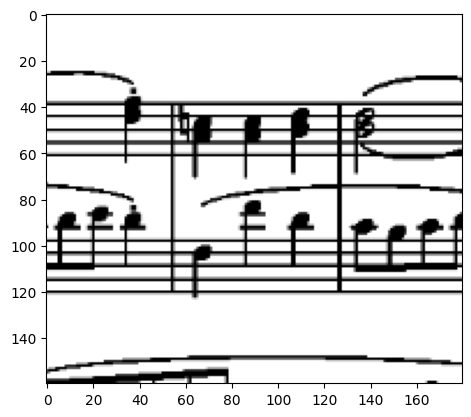

In [77]:

# plt.figure('specs', figsize=(30,30))

pieces_folder_names = ['PleyelIJ__pleyel-menuett__pleyel-menuett']#, 'SmallwoodW__the_harebell__the_harebell', 'PleyelIJ__pleyel-menuett__pleyel-menuett']
piece_pools =  []
order = 1

# Creatp
# for i in tqdm(range(len(pieces_folder_names))):
for i in tqdm(range(len(pieces_folder_names))):
    piece_name = pieces_folder_names[i]

    try:
        piece = Piece(root=DATA_ROOT_MSMD, name=piece_name)
        performances =  piece.available_performances
        if len(piece.available_scores)==0 or len(performances)==0:
            continue
        piece_image, piece_specs, piece_o2c_maps, systems = prepare_piece_data(DATA_ROOT_MSMD, piece_name,
                                                    aug_config=augment, require_audio=False, get_system_index=True)
        piece_pool = AudioScoreRetrievalPool([piece_image], [piece_specs], [piece_o2c_maps], 
                                            spec_context=SPEC_CONTEXT, sheet_context=SHEET_CONTEXT, staff_height=SYSTEM_HEIGHT, 
                                            data_augmentation=test_augment, shuffle=False)
        print(len(systems), len(piece_o2c_maps), len(piece_pool.o2c_maps), len(piece_pool.o2c_maps[0]))
        
        
        piece_pools.append(piece_pool)

    #     snippets_piece_dir = os.path.join(snippets_output_dir, piece_name)
    #     sheet_snippets_dir = os.path.join(snippets_piece_dir, 'sheet_snippets')
    #     exceprt_snippets_dir = os.path.join(snippets_piece_dir, 'performances')

        # iterate sheets 
        for i_sheet, sheet in enumerate(piece_pool.images):

            # iterate spectrograms
            # for i_spec, spec in enumerate(piece_pool.specs[i_sheet]):
            for i_spec, spec in enumerate(piece_pool.specs[i_sheet][:1]):
                # sheet_dir = os.path.join(sheet_snippets_dir, performances[i_spec])
                # exceprt_dir = os.path.join(exceprt_snippets_dir, performances[i_spec])
                
                for i_onset in range(len(piece_pool.o2c_maps[i_sheet][i_spec])):
                    # print(f'I_onset: {i_onset}: {piece_pool.o2c_maps[i_sheet][i_spec][i_onset]} | {(systems[0][i_onset])}')
                    # system_el_index = piece_pool.o2c_maps[i_sheet][i_spec][i_onset][1]
                    # system_el= systems[system_el_index]
                    # print(f'so : {i_sheet, i_spec, i_onset} {systems[0][i_onset]}')
                    if systems[0][i_onset][1] == 0:
                        snippet = piece_pool.prepare_train_image(i_sheet, i_spec, i_onset)
                        plt.imshow(snippet, cmap='gray')
        #                 print(f'{sheet_dir}/{performances[i_spec]}_{i_onset}.png', system_el)
    #                     excerpt = cv2.imread(f'{sheet_dir}/{performances[i_spec]}_{i_onset}.png', cv2.IMREAD_GRAYSCALE)
    #                     # print(excerpt.shape)
    #                     # # plt.plot(except.shape[], note_object.middle[0], 'go', markersize=20, alpha=.6)
    #                     # # plt.plot([excerpt.shape[1]/2, excerpt.shape[1]/2], [0, excerpt.shape[0]], 'r-', alpha=.6, linewidth=8)


    #                     # plt.subplot(5, 4, order)
    #                     # order +=1
    #                     # plt.imshosw(excerpt, cmap='gray')
    #                     # plt.title(f'{order} {piece.available_performances[i_spec].split("_")[-1].split(".")[0]} | {system_el}')

    except:
        print("Problems with loading piece %s" % piece_name)
        print(sys.exc_info()[0])
        continue


In [ ]:
# Sort assign the id starting from 0 - already sorted
# system_mungos = sorted(system_mungos, key=lambda m: m.top)
